# Equilibrium states

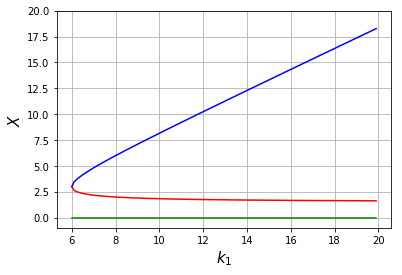

In [209]:
import math
X_0=[]
X_1=[]
X_2=[]
k_1=[float(i)/10 for i in list(range(60,200,1))]
D=[]
for i in k_1:
    params=[i,1,1,1.5] #k1,k2,k3,k4
    X_0.append(0)
    X_1.append((-params[1]+math.sqrt(params[1]*params[1]-4*params[1]*params[2]*params[3]/params[0]))/(-2*params[1]*params[2]/params[0]))
    X_2.append((-params[1]-math.sqrt(params[1]*params[1]-4*params[1]*params[2]*params[3]/params[0]))/(-2*params[1]*params[2]/params[0]))

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(k_1,X_0,c='green')
plt.plot(k_1,X_1,c='red')
plt.plot(k_1,X_2,c='blue')
plt.xlabel('$k_1$',size=15)
plt.ylabel('$X$',size=15)
plt.ylim(-1,20)
plt.grid()

# Trajectories

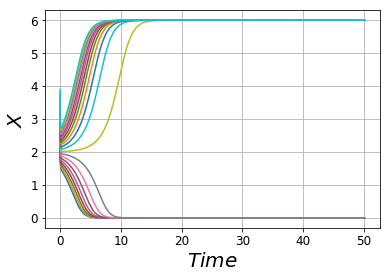

In [2]:
#Rate equations
def dX(X,Y,params):
    return (2*params[0]*Y[-1]-params[1]*X[-1]*X[-1]-params[2]*X[-1]*Y[-1]-params[3]*X[-1])

def dY(X,Y,params):
    return (-params[0]*Y[-1]+params[1]*X[-1]*X[-1])

#Trajectory function
def trajectory(params,dt,init,t):
    import pandas as pd
    run=pd.DataFrame(columns=['X','Y','t'])
    run=run.append(pd.DataFrame(data={'X':[init[0]],'Y':[init[1]],'t':[0]}))
    while list(run['t'])[len(run)-1]<t:
        next_X=dX(list(run['X']),list(run['Y']),params)*dt+list(run['X'])[len(run)-1]
        next_Y=dY(list(run['X']),list(run['Y']),params)*dt+list(run['Y'])[len(run)-1]
        next_t=list(run['t'])[len(run)-1]+dt
        run=run.append(pd.DataFrame(data={'X':[next_X],'Y':[next_Y],'t':[next_t]}))
    return run

import matplotlib.pyplot as plt
%matplotlib inline
for i in list(range(20,40,1)):
    init=[float(i)/10,float(0)]
    params=[8,1,1,1.5] #k1,k2,k3,k4
    t=50
    dt=0.05
    run=trajectory(params,dt,init,t)
    plt.plot(run['t'],run['X'])

plt.xlabel('$Time$',size=20)
plt.ylabel('$X$',size=20)
plt.xticks(size=12)
plt.yticks(size=12)
plt.grid()
plt.show()

# Steady-states at different initial conditions

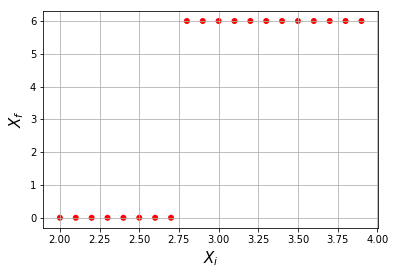

In [35]:
Xf=[]
Xi=[]
for i in list(range(20,40,1)):
    init=[float(i)/10,0]
    params=[8,1,1,1.5] #k1,k2,k3,k4
    t=50
    dt=0.05
    run=trajectory(params,dt,init,t)
    Xf.append(list(run['X'])[-1])
    Xi.append(float(i)/10)

plt.scatter(Xi,Xf,c='red',edgecolors='none')
plt.xlabel('$X_i$',size=15)
plt.ylabel('$X_f$',size=15)
plt.grid()
plt.show()

# Numerical continuation

In [111]:
import PyDSTool as dst
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# we must give a name
DSargs=dst.args(name='Simplest bistable model')
# parameters
DSargs.pars={'k1':8,
             'k2':1,
             'k3':1,
             'k4':1.5}
# rhs of the differential equation, including dummy variable w
DSargs.varspecs={'x':'2*k1*y-k2*x*x-k3*x*y-k4*x',
                 'y':'k2*x*x-k1*y'}
# initial conditions
DSargs.ics={'x':3,'y':0}

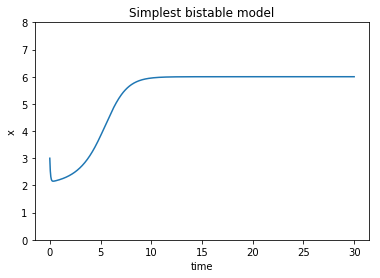

In [112]:
DSargs.tdomain=[0,30]                       # set the range of integration.
ode=dst.Generator.Vode_ODEsystem(DSargs)    # an instance of the 'Generator' class.
traj=ode.compute('bistability')             # integrate ODE
pts=traj.sample(dt=0.05)                    # Data for plotting

# PyPlot commands
plt.plot(pts['t'],pts['x'])
plt.xlabel('time')                          # Axes labels
plt.ylabel('x')                             # ...
plt.ylim([0,8])                             # Range of the y axis
plt.title(ode.name)                         # Figure title from model name
plt.show()

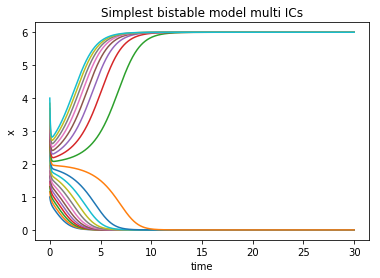

In [114]:
for i,x0 in enumerate(np.linspace(1,4,20)):
    ode.set(ics={'x':x0})                       # Initial condition
    # Trajectories are called pol0, pol1, ...
    # sample them on the fly to create Pointset tmp
    tmp=ode.compute('pol%3i'%i).sample()        # or specify dt option to sample to sub-sample
    plt.plot(tmp['t'],tmp['x'])
plt.xlabel('time')
plt.ylabel('x')
plt.title(ode.name+' multi ICs')
plt.show()

LP Point found 


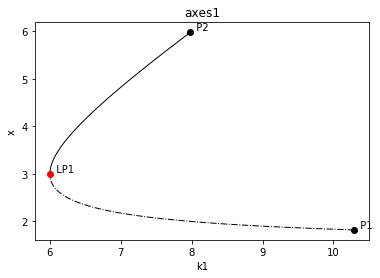

In [236]:
# Prepare the system to start close to a steady state
ode.set(pars={'k1':4})       # Lower bound of the control parameter 'k1'
ode.set(ics={'x':2.3})       # Close to one of the steady states present for k1=6

PC=dst.ContClass(ode)        # Set up continuation class

PCargs=dst.args(name='EQ1',type='EP-C')       # 'EP-C' stands for Equilibrium Point Curve. The branch will be labeled 'EQ1'.
PCargs.freepars     = ['k1']                  # control parameter(s) (it should be among those specified in DSargs.pars)
PCargs.MaxNumPoints = 100                     # The following 3 parameters are set after trial-and-error
PCargs.MaxStepSize  = 0.1
PCargs.MinStepSize  = 0.5
PCargs.StepSize     = 0.05
PCargs.LocBifPoints = 'LP'                    # detect limit points / saddle-node bifurcations
PCargs.SaveEigen    = True                    # to tell unstable from stable branches

PC.newCurve(PCargs)
PC['EQ1'].forward()
PC.display(['k1','x'],stability=True,figure=1)# stable and unstable branches as solid and dashed curves, resp.